In [1]:
import numpy as np

# Expected Value of Cost function in population setting
## Projecting $p$ entries as sigmoids 
We have 

$$C(A, P) = \text{Tr}\left((B^* - B)\Sigma_X(B^* - B)\right),$$

where $$B = P^{-1}AP.$$

Here, $A$ is lower triangular and $P$ is a doubly stochastic matrix, namely

\begin{align*}
0 \leq &p_{ij} &\forall\ i,j = 1, \cdots, n\\
\sum_{j = 1}^n &p_{ij} = 1&\forall\ i = 1, \cdots, n\\
\sum_{i=1}^n &p_{ij} = 1 &\forall\ j = 1, \cdots, n\\
\end{align*}

In [1738]:
# actual solution
n = 5
As = np.tril(np.random.rand(n, n))
Ps = np.identity(n)
Sigma = np.identity(n)

print(f"A*:\n{np.round(As, 2)}\n\nP*:\n{Ps}")

A*:
[[0.21 0.   0.   0.   0.  ]
 [0.87 0.06 0.   0.   0.  ]
 [0.39 0.42 0.95 0.   0.  ]
 [0.44 0.9  0.99 0.35 0.  ]
 [0.51 0.7  0.73 0.09 0.45]]

P*:
[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [1739]:
def expected_cost(A, P, As = As, Ps = Ps):
    # base on the distribution of X, no actual data needed.
    # we need the covariance of X_t - X_{t-1}.
    # Then, the expected cost is the trace of this covariance
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))
    
    covariance_matrix = Sigma + np.matmul((Bs - B), np.matmul(covariance_X, (Bs - B).transpose()))
    
    return np.trace(covariance_matrix)

A = np.random.rand(n, n)
P = np.identity(n)
print(f"Expected cost: {expected_cost(np.random.rand(n,n), Ps)}.")

Expected cost: 221.91943464693176.


## Dealing with the constraints
### Non-negativity constraints
To deal with the $n^2$ equality constraints, we use non-negative $\textit{lagrange multipliers}$ $\lambda_{ineq, i, j} \geq 0$, $i, j = 1, \cdots, n$. The dual function now becomes 

$$\mathcal{L}(A, P_\sigma, \mathbf{\lambda}) = C(A, P) - \sum_{i=1}^n\sum_{j=1}^n \lambda_{ineq,i,j} \left(-p_{ij}\right).$$


## Dealing with equality constraints
To deal with the $2n$ equality constraints, we use $\textit{lagrange multipliers}$ $\lambda_{row, i}$, $i = 1, \cdots, n$ and $\lambda_{col, j}$, $j = 1, \cdots, n$. The dual function now becomes 

$$\mathcal{L}(A, P_\sigma, \mathbf{\lambda}) = C(A, P) - \sum_{i=1}^n\sum_{j=1}^n \lambda_{ineq,i,j} \left(-p_{ij}\right) - \sum_{i=1}^n \lambda_{row, i} \left(\sum_{j = 1}^n p_{ij} - 1\right) - \sum_{j = 1}^n \lambda_{col, j} \left(\sum_{i = 1}^n p_{ij} - 1\right).$$

In [1740]:
def expected_cost_lagrange(A, P, As = As, Ps = Ps):
    exp_cost = expected_cost(A, P)
    lambda_cost = 0
    
    for i in range(n):
        lambda_cost += lambdas[0][i] * (sum(P[:, i]) - 1)
        lambda_cost += lambdas[1][i] * (sum(P[i]) - 1)
        
    return exp_cost - lambda_cost - np.sum(lambdasineq * P)

lambdas = np.zeros((2, n))
lambdasineq = np.zeros((n, n))
P = np.ones((n, n)) / n + np.random.rand(n, n) / n
print(f"Expected lagrange cost: {expected_cost(np.random.rand(n,n), Ps)}.")

Expected lagrange cost: 113.25168812805727.


## Optimizing $\mathcal{L}(A, P_\sigma, \mathbf{\lambda})$
let $$q(\mathbf{\lambda}) = \inf_{A, P} \mathcal{L}(A, P, \mathbf{\lambda}).$$
Then the $\textit{dual problem}$ is $$\max_{\mathbf{\lambda}} q(\mathbf{\lambda}).$$

## Deriving $q(\mathbf{\lambda})$
To minimize $\mathcal{L}(A, P_\sigma, \mathbf{\lambda})$, we will use gradient descent.

The partial derivative with respect to entries in $A$ is simple, 

$$\frac{\partial\mathcal{L}(A, P, \mathbf{\lambda})}{\partial a_{ij}} = \frac{\partial C(A, P)}{\partial a_{ij}}$$

Now, the partial derivative with respect to the entries in $p$ is more involved as it occurs also in exactly two equality constraints, namely in $\lambda_{row, i}$ and in $\lambda{col, j}$.

$$\frac{\partial\mathcal{L}(A, P_\sigma, \mathbf{\lambda})}{\partial p_{ij}} = \frac{\partial C(A, P)}{\partial p_{ij}} - \lambda_{ineq, i, j} - \lambda_{row, i} - \lambda_{col, j}.$$

Now, as $C(A, P)$ is unfortunately yet inevitably non-convex, we cannot expect to find the infimum $q(\mathbf{\lambda})$. However, let us consider a local minimum $\tilde{q}(\mathbf{\lambda})$, which we will find by gradient descent. 

For a sufficiently small step size, we will do this gradient descent until we have found a stationary point:
$$(A_{t + 1}, P_{t + 1}) = (A_t, P_t) - \eta\ \nabla \mathcal{L}(A_t, P_t, \mathbf{\lambda})$$
Note that this is an $\textit{unconstrained}$ optimization problem now, which should make things more easy. 

Suppose that after a number of iterations, we have found this local minimum with parameters $\tilde{A}$, $\tilde{P}$. Then, we have that $$\tilde{q}(\mathbf{\lambda}) = \mathcal{L}(\tilde{A}, \tilde{P}, \mathbf{\lambda}).$$

In [1741]:
# get gradient of our outcome
def grad_a(A, P, i, j, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

    return -2 * np.trace(np.matmul(covariance_X, np.matmul((Bs - B).transpose(), np.matmul(P_inv, np.matmul(J, P)))))

def grad_p(A, P, i, j, As = As, Ps = Ps):
    P_inv = np.linalg.inv(P)
    Ps_inv = np.linalg.inv(Ps)
    
    B = np.matmul(P_inv, np.matmul(A, P))
    Bs = np.matmul(Ps_inv, np.matmul(As, Ps))
    
    J = np.zeros((n, n))
    J[i][j] = 1
    
    covariance_X = np.matmul(np.linalg.inv(np.identity(n ** 2) - np.kron(Bs, Bs)), Sigma.reshape(n ** 2)).reshape((n, n))

    B_grad = np.matmul(P_inv, np.matmul(A, J))
    B_grad -= np.matmul(P_inv, np.matmul(J, np.matmul(P_inv, np.matmul(A, P))))
    
    return -2 * np.trace(np.matmul(covariance_X, np.matmul((Bs - B).transpose(), B_grad))) - lambdasineq[i][j] - lambdas[0][j] - lambdas[1][i]

def get_gradient(A, P):
    gradient = np.zeros(int(n * (n + 1) / 2 + n ** 2))
    index = 0
    
    for i in range(n):
        for j in range(i + 1):
            gradient[index] = grad_a(A, P, i, j)
            index += 1
            
    for i in range(n):
        for j in range(n):
            gradient[index] = grad_p(A, P, i, j)
            index += 1
            
    return gradient

## Deriving the dual problem
Now that we have $\tilde{q}(\mathbf{\lambda})$, the solution to the dual problem is
$$\max_{\lambda} \tilde{q}(\mathbf{\lambda}),$$
which is again an unconstrained optimization problem, which we can also optimize by maximizing $\lambda$'s.

## Final Algorithm
To solve this problem, we simply iterate the following:
- While $\nabla \mathcal{L}(A_t, P_t, \mathbf{\lambda}) \geq 0$:
    - $(A_{t + 1}, P_{t + 1}) = (A_t, P_t) - \eta\ \nabla \mathcal{L}(A_t, P_t, \mathbf{\lambda})$
    - $\lambda_{ineq, i, j} = max(0, p_{ij})\ \forall i, j = 1, \cdots, n$
    - $\lambda_{row, i} = 1 - \sum_{j=1}^n p_{ij} \ \forall i = 1, \cdots, n$
    - $\lambda_{col, j} = 1 - \sum_{i=1}^n p_{ij} \ \forall j = 1, \cdots, n$
    
We will end up in a local optimum of $C(A, P)$ while also fullfilling the constraints.

In [1899]:
# Initial values
A = np.zeros((n, n))
P = np.ones((n, n)) / n + np.random.rand(n, n) / n
lambdas = np.zeros((2, n))
lambdasineq = np.zeros((n, n))

In [1896]:
# step size
eta = 1e-4

In [ ]:
# the algorithm
grad = get_gradient(A, P)

# while gradient is larger than zero (or a value close)
while np.sum(np.abs(grad)) > 0.00001:
    
    # get gradient
    A_grad = np.zeros((n , n))
    A_grad[np.tril_indices(n)] = grad[:int(n * (n + 1) / 2)]
    P_grad = grad[int(n * (n + 1) / 2):].reshape((n , n))

    # update A and B according to gradient
    A -= eta * A_grad / 2
    P -= eta * P_grad / 2
    
    # recompute gradient
    grad = get_gradient(A, P)
    
    print("Gradient:", np.sum(np.abs(grad)))
    print(expected_cost_lagrange(A, P))    
    
    # update equality constraints
    for row_or_col in range(2):
        for i in range(n):
            lagrange[row_or_col][i] = grad_lambda(A, P, i, row_or_col)

    # update equality constraints
    lambdas = lagrange
    
    # update inequality constraints
    lambdasineq = np.maximum(np.zeros((n, n)), -P)

## Verification
First of all, let us look at $A$ and $P$. These should adhere to the constraints. We indeed see this is the case. Furthermore, let us look at our lambdas, they should all be (closely) equal to zero. Furthermore, let us look at the gradients, all gradients, as well as with respect to lambda, should be close to zero. Lastly, the expected cost of the lagrangian and the regular expected cost should be close to the global optimum, which is the trace of $\Sigma$.

In [1873]:
print(f"A:\n{A}\n\nP:\n{P}\n\nEquality constraints:\n{lambdas}\n\nInequality constraints:\n{lambdasineq}\n")
print(f"Gradients:\n{get_gradient(A, P)}\n")
print(f"Expected Cost: {expected_cost(A, P)}\nLagrange expected cost: {expected_cost_lagrange(A, P)}")

A:
[[ 0.9442672   0.          0.          0.          0.        ]
 [ 0.71139131 -0.19192319  0.          0.          0.        ]
 [ 1.75291726 -0.32849846  0.44185863  0.          0.        ]
 [ 0.63860386  0.44843064 -0.00387412  0.48694836  0.        ]
 [ 1.20204355  0.21413035 -0.02164681  0.65558752  0.26328157]]

P:
[[ 0.44708326  0.24508246  0.36591829  0.02864792 -0.01100267]
 [ 0.80601479 -0.07304353  0.20709414  0.06199506 -0.03471924]
 [-0.0460941   0.17048895  0.31141212  0.23315074  0.28066933]
 [-0.05656503  0.45570727  0.29985604  0.06918093  0.20110257]
 [-0.08487268  0.30086738 -0.15134379  0.45378829  0.48334898]]

Equality constraints:
[[-0.06556635 -0.09910235 -0.03293696  0.15323751  0.08060067]
 [-0.07572941  0.0326587   0.05037301  0.03071824 -0.00178802]]

Inequality constraints:
[[0.         0.         0.         0.         0.01100281]
 [0.         0.07304365 0.         0.         0.03471949]
 [0.04609428 0.         0.         0.         0.        ]
 [0.05656484

In [1474]:
# optimize dual
def grad_lambda(A, P, i, row_or_col):
    if row_or_col:
        return - np.sum(P[i]) + 1
    else:
        return - np.sum(P[:, i]) + 1

lambdas = np.zeros((2, n))
for row_or_col in range(2):
    for i in range(n):
        lagrange[row_or_col][i] = grad_lambda(A, P, i, row_or_col)

print(np.sum(np.abs(lagrange)))
# lambdas += lagrange
print(lambdas)

2.7213035548090403e-05
[[0. 0. 0.]
 [0. 0. 0.]]


In [1632]:
print(P)
print(P[:,0].sum())
print(P[:,1].sum())
print(P[:,2].sum())
print(P[0].sum())
print(P[1].sum())
print(P[2].sum())

print(A)

[[ 0.78786133  0.03749397  0.17483012]
 [ 0.21388269  0.44774375  0.33790395]
 [-0.00108668  0.51584377  0.48563721]]
1.0006573329784478
1.0010814907678938
0.9983712778229797
1.0001854181168865
0.9995303847401568
1.000394298712278
[[ 0.53651724  0.          0.        ]
 [ 0.55660099  0.16752795  0.        ]
 [ 0.60872731 -0.10241169  0.29617121]]


In [1832]:
print(np.matmul(np.linalg.inv(P), np.matmul(A, P)))

[[ 0.17998707  0.08905369 -0.01265405 -0.02612188  0.02989728]
 [ 0.85167812  0.05597693 -0.04137906  0.03272593 -0.00625724]
 [ 0.34190774  0.44203072  0.92970935  0.06616251 -0.05281964]
 [ 0.45130809  0.85840495  0.99574185  0.32153006  0.02691043]
 [ 0.53068155  0.65829438  0.6948119   0.11089456  0.45839715]]


In [1833]:
print(np.matmul(np.linalg.inv(Ps), np.matmul(As, Ps)))

[[0.21212736 0.         0.         0.         0.        ]
 [0.87177441 0.05978334 0.         0.         0.        ]
 [0.3881885  0.41522956 0.94850424 0.         0.        ]
 [0.4417668  0.90098613 0.99231299 0.35049124 0.        ]
 [0.51463189 0.69599484 0.73467549 0.09184872 0.45206036]]


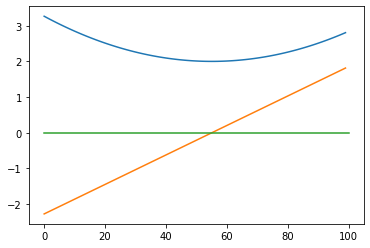

In [1718]:
# verify gradients
a_list = np.linspace(-1, 1, 100)
A2 = As.copy()

i, j = 1, 1

results = [[], []]

for a in a_list:
    A2[i][j] = a
    results[0].append(expected_cost_lagrange(A2, P, As = As, Ps = Ps))
    results[1].append(grad_a(A2, P, i, j))

import matplotlib.pyplot as plt
plt.plot(results[0])
plt.plot(results[1])
plt.plot([0, 100],[0, 0])

-0.034870339745329826


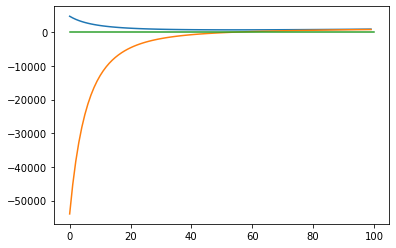

In [1871]:
# verify gradients
p_list = np.linspace(0, 1, 100)
P2 = P.copy()

lambdas = 0.1 * np.ones((2, n))
i, j = 1, 4
print(P[i][j])


results = [[], []]

for p in p_list:
    P2[i][j] = p
    results[0].append(expected_cost_lagrange(As, P2, As = As, Ps = Ps))
    results[1].append(grad_p(As, P2, i, j))

import matplotlib.pyplot as plt
plt.plot(results[0])
plt.plot(results[1])
plt.plot([0, 100],[0, 0])

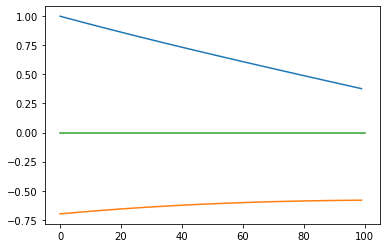

In [1723]:
# verify gradients
p_list = np.linspace(0, 1, 100)
P2 = Ps.copy()

lambdas = 0.1 * np.ones((2, n))
lambdasineq = 0.5 * np.ones((n, n))

i, j = 0, 1

results = [[], []]

for p in p_list:
    P2[i][j] = p
    results[0].append(expected_cost_lagrange(As, P2, As = As, Ps = Ps))
    results[1].append(grad_p(As, P2, i, j))

import matplotlib.pyplot as plt
plt.plot(results[0])
plt.plot(results[1])
plt.plot([0, 100],[0, 0])

To deal with the constraints that $p$ must be non-negative, we project the entries by applying the sigmoid function of each entry. Note that the range of the sigmoid is $(0, 1)$, which is also what we require for our entries $p$ (we did not explicitly constrain $p$ to be smaller than 1, but the equality constraints combined with the non-negativity constraints make sure that is the case.
To deal with the $2n$ equality constraints, we use $\textit{lagrange multipliers}$ $\lambda_{row, i}$, $i = 1, \cdots, n$ and $\lambda_{col, j}$, $j = 1, \cdots, n$. The dual function now becomes 

$$\mathcal{L}(A, P_\sigma, \mathbf{\lambda}) = C(A, P) - \sum_{i=1}^n \lambda_{row, i} \left(\sum_{j = 1}^n p_{ij} - 1\right) - \sum_{j = 1}^n \lambda_{col, j} \left(\sum_{i = 1}^n p_{ij} - 1\right),$$
where $P = \sigma(P_\sigma)$